## Dependencies

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import metric_learn
from matplotlib import style
style.use('ggplot')

## Embeddings summary

In [36]:
## Embedding created from type of data (binary or normalized) 
type_dict ={'b':'Binary', 'n' : 'Normalized'}
emb_type = 'b' # b: binary; n: normalized 
emb_dim = 197 # emb dimension 197 or 99

## Import the embeddings
path = 'data/embeddings_{}_{}.npy'.format(emb_dim,emb_type)
emb = np.load(path)

print('{} embeddings loaded'.format(type_dict[emb_type]))
print("Embeddings are of the shape {}".format(emb.shape))
print("Column {} is the labels corresponding to each embedding".format(emb.shape[1]))

Binary embeddings loaded
Embeddings are of the shape (70000, 197)
Column 197 is the labels corresponding to each embedding


# Vanilla KNN on Embeddings

In [9]:
## splitting into test and train embeddings
np.random.seed(42)
idx = np.random.permutation(70000)
emb_train = emb[idx[:60000]]
emb_test = emb[idx[60000:]]

In [10]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
#emb_train = emb[idx[:60000]]
#emb_test = emb[idx[60000:]]
#emb_test = emb_train
k_test = 200
predictions = dict()

for k in range(1,k_test+1) : predictions[k] = list()

for n,test_inst in enumerate(emb_test):
    
    print(n)
    ## Calculate the distance of each test instance from train instances 
    test_inst = test_inst[:-1]
    test_inst = test_inst.reshape(1,-1)
    test_inst = test_inst.repeat(len(emb_train), axis=0)
    temp_dist = np.linalg.norm((test_inst - emb_train[:,:-1]), axis=1)

    ## Store distance and respective labels in tuples in a list
    temp_dist_idx = [(temp_dist[i],emb_train[i,-1]) for i in range(len(emb_train))]
    temp_dist_idx.sort()

    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])

path = "data/predictions_knn_{}_{}".format(emb_dim,emb_type)
with open(path + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

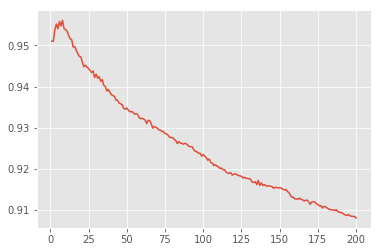

In [11]:
"""
## Load prediciton list 
with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f) """

## Calculate accuracy 
accuracy = list()
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))
    
## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [12]:
idx = round(np.sqrt(60000/2)) # for k = sqrt(n/2)
print("Accuracy at {} = {}".format(idx, accuracy[int(idx-1)][0]))

Accuracy at 173.0 = 0.912


# CNN on Embeddings

**To use relevant indices, simply unpickle the list 'relevant_idx' and extract corresponding 
rows within the 'train_X' matrix**

In [14]:
def eucl_dist(instance, dataset):
    
    temp_inst = instance.reshape(1,-1)
    temp_inst = temp_inst.repeat(len(dataset), axis=0)
    eucl_dist = np.linalg.norm((temp_inst - dataset[:,:-2]), axis=1)
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-2]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted


## Removing the Bayesian Error

In [15]:
"""
- Remove Baysean error
    - Create 2 subsets
    - Find 1NN of instances from subset 1 using subset 2
        - classify them : Delete wrongly classified instances
    -  Find 1NN of instances from subset 2 using subset 1
        - classify them : Delete wrongly classified instances
    - Repeat until stability 
"""
#emb_dim = 197
#path = 'data/embeddings_{}.npy'.format(emb_dim)
#emb = np.load(path)

## Adding indices to the embeddings (to keep track of them)
track_idx = np.array([i for i in range(len(emb))]).reshape(-1,1)
emb = np.concatenate((emb, track_idx), axis = 1)

## Creating subsets for CNN algo
train_subset_1 = emb[:30000]
train_subset_2 = emb[30000:60000]
track_unwanted = list() # store irrelevant indices

stability = False
prev_len_subset_1 = len(train_subset_1)
prev_len_subset_2 = len(train_subset_2)

itr = 0
while not stability:
    
    itr += 1
    print(itr)
    
    temp_unwanted = list()
    
    for n_1,sub_1 in enumerate(train_subset_1):
        
        
        eucl_dist_sorted = eucl_dist(sub_1[:-2], train_subset_2)
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]

        ## Store indices in unwated list if class is wrong
        if temp_label != sub_1[-2]:
            temp_unwanted.append(n_1)
            track_unwanted.append(sub_1[-1])
            
    ## Delete rows of train_subset_1 whose indices lie within the list 'temp_unwanted'  
    train_subset_1 = np.delete(train_subset_1, temp_unwanted, axis=0)
    
    ## Save train_subset_1
    np.save('data/train_subset_1_{}'.format(itr), train_subset_1)
    
    print(itr)
    
    temp_unwanted = list()
    
    for n_2,sub_2 in enumerate(train_subset_2):
        
        eucl_dist_sorted = eucl_dist(sub_2[:-2], train_subset_1)
        
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]
        
        ## Store indices in unwated list if class is wrong
        if temp_label != sub_2[-2]:
            temp_unwanted.append(n_2)
            track_unwanted.append(sub_2[-1])
            
    ## Delete rows of train_subset_1 whose indices lie within the list 'temp_unwanted'  
    train_subset_2 = np.delete(train_subset_2, temp_unwanted, axis=0)
            
    np.save('data/train_subset_2_{}'.format(itr), train_subset_2)
    
    if prev_len_subset_1 == len(train_subset_1) and prev_len_subset_2 == len(train_subset_2):
        stability = True
        
    else: 
        prev_len_subset_1 = len(train_subset_1)
        prev_len_subset_2 = len(train_subset_2)
      
        

1
1
2
2
3
3


In [ ]:
train_subset_1 = np.load('data/train_subset_1_3.npy')
train_subset_2 = np.load('data/train_subset_2_3.npy')
print(train_subset_1.shape, train_subset_2.shape)

## Condensed Nearest Neighbours

In [16]:
"""
- Remove instances that can be easily classified
    - Find 1NN neighbours of every instance with every other
    - if class of instance == class of other instance : Delete
    - elif class of instance != class of other instance : Keep
    
"""

## train_subset_1 union train_subset_2 
train_emb_bay = np.concatenate((train_subset_1,train_subset_2), axis = 0)

## Creating storage for relevant instances
random_idx = np.random.choice(len(train_emb_bay),1)
STORAGE = train_emb_bay[random_idx]

stability = False

prev_storage_len = len(STORAGE)
itr = 0 

while not stability:
    
    itr += 1
    print(itr)
    
    for inst in train_emb_bay:
        
        # Calc list sorted by ascending order of euc distance
        eucl_dist_sorted = eucl_dist(inst[:-2], STORAGE)
        
        # Choose first element from sorted list 'temp_dist_idx'
        temp_first_nn = eucl_dist_sorted[0]
        temp_label = temp_first_nn[1]
        
        # Store indices in unwated list if class is wrong
        if temp_label != inst[-2]:
            STORAGE = np.concatenate((STORAGE, inst.reshape(1,-1)), axis = 0)
        
        else:continue 
    
    #np.save('data/STORAGE_{}'.format(itr), STORAGE)

    if prev_storage_len == len(STORAGE):
        stability = True
        print("now")
    
    else:
        prev_storage_len = len(STORAGE)
        print(len(STORAGE))
        print(prev_storage_len)
            
    

1
4020
4020
2
4977
4977
3
5106
5106
4
5120
5120
5
now


In [19]:
#STORAGE = np.load('data/STORAGE_4.npy')
relevant_idx_b = list()
for i in range(len(STORAGE)):
    relevant_idx_b.append(STORAGE[i,-1])

In [21]:
with open("relevant_idx_{}_b".format(emb_dim), "wb") as fp:   #Pickling
    pickle.dump(relevant_idx_b, fp)

"""with open("relevant_idx", "rb") as fp:   # Unpickling
b = pickle.load(fp)"""

'with open("relevant_idx", "rb") as fp:   # Unpickling\nb = pickle.load(fp)'

In [32]:
len(relevant_idx_b)

5120

In [34]:
from collections import Counter

In [35]:
Counter(emb_train[:,-1])

Counter({0.0: 223,
         1.0: 162,
         2.0: 502,
         3.0: 765,
         4.0: 603,
         5.0: 691,
         6.0: 283,
         7.0: 529,
         8.0: 737,
         9.0: 625})

In [9]:
with open("relevant_idx", "rb") as fp:   # Unpickling
    relevant_idx = pickle.load(fp)
    
relevant_idx = [int(i) for i in relevant_idx]
emb_imp = emb[relevant_idx]

In [34]:
list_idx = dict()
for i in range(10): list_idx[i] = list()
    
for n,i in enumerate(emb_imp[:,-1]): list_idx[i].append(n)

In [35]:
small_relevant_idx = list()
for i in range(10): small_relevant_idx.extend(np.random.choice(list_idx[i],100,replace=False))

# KNN on strong examples (after CNN)

In [27]:
with open("relevant_idx", "rb") as fp:   # Unpickling
    relevant_idx = pickle.load(fp)
    
    
relevant_idx_b = [int(i) for i in relevant_idx_b]
emb_train = emb[relevant_idx_b]
emb_train.shape

(5120, 197)

In [28]:
#emb_train = emb[relevant_idx_b]

In [29]:
  """
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
#emb_train = emb[idx[:60000]]
emb_test = emb[60000:]
#emb_test = emb_train
k_test = 100
predictions = dict()

for k in range(1,k_test+1) : predictions[k] = list()

for n, test_inst in enumerate(emb_test):
    print(n)
    ## Calculate the distance of each test instance from train instances 
    test_inst = test_inst[:-1]
    test_inst = test_inst.reshape(1,-1)
    test_inst = test_inst.repeat(len(emb_train), axis=0)
    temp_dist = np.linalg.norm((test_inst - emb_train[:,:-1]), axis=1)

    ## Store distance and respective labels in tuples in a list
    temp_dist_idx = [(temp_dist[i],emb_train[i,-1]) for i in range(len(emb_train))]
    temp_dist_idx.sort()

    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])

name = "data/predictions_knn_cnn_small"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

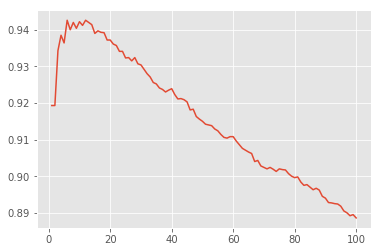

In [30]:
## Calculate accuracy 
accuracy = list()
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))

## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [31]:
idx = int(round(np.sqrt(5000/2)))  # for k = sqrt(n/2)
print("Accuracy at {} = {}".format(idx, accuracy[idx-1][0]))

Accuracy at 50 = 0.915


# Metric Learning

## With Relevant Examples

In [192]:
with open("relevant_idx", "rb") as fp:   # Unpickling
    relevant_idx = pickle.load(fp)
    
relevant_idx = [int(i) for i in relevant_idx]
emb_train = emb[relevant_idx]

In [45]:
X = emb_train[:,:-1]
Y = emb_train[:,-1]

### LMNN

In [55]:
# setting up LMNN
lmnn = metric_learn.LMNN(k=20, learn_rate=1e-2)

# fit the data!
lmnn.fit(X, Y)

# transform our input space
X_lmnn = lmnn.transform()

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


In [56]:
def eucl_dist_metric(instance, dataset, matrix_m):
    
    temp_inst = instance.reshape(1,-1)
    temp_inst = temp_inst.repeat(len(dataset), axis=0)
    difference = temp_inst - dataset[:,:-1]
    eucl_dist = np.diag(np.sqrt(np.matmul(np.matmul(difference, matrix_m),difference.T)))
    #eucl_dist = np.linalg.norm((temp_inst - dataset[:,:-2]), axis=1)
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-1]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted


In [57]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""

emb_test = emb[60000:]
k_test = 100
predictions = dict()
matrix_m = lmnn.metric()

for k in range(1,k_test+1) : predictions[k] = list()

for n, test_inst in enumerate(emb_test):
    print(n)
    ## Calculate the distance of each test instance from train instances 
    eucl_dist_sorted = eucl_dist_metric(test_inst[:-1], emb_train, matrix_m)
    
    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = eucl_dist_sorted[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])

name = "data/predictions_knn_cnn_metric_small"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)

0
1
2
3
4
5


/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
28

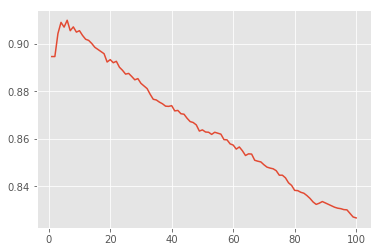

In [58]:
"""
name = "predictions_knn_cnn_metric"
with open(name + '.pkl', 'rb') as f:
    predictions = pickle.load(f)
"""
## Calculate accuracy 
accuracy = list()
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))
    
## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [59]:
idx = int(round(np.sqrt(1000/2)))  # for k = sqrt(n/2)
print("Accuracy at {} = {}".format(idx, accuracy[idx-1][0]))

Accuracy at 22 = 0.8927


### ITML

In [78]:
itml = metric_learn.ITML_Supervised(num_constraints=200)
X_itml = itml.fit_transform(X, Y)

In [79]:
"""
## To-Do
- Try the same on the only the MNIST datasets

- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
#emb_train = emb[idx[:60000]]
emb_test = emb[60000:61000]
#emb_test = emb_train
k_test = 100
predictions = dict()

for k in range(1,k_test+1) : predictions[k] = list()

for n, test_inst in enumerate(emb_test):
    print(n)
    ## Calculate the distance of each test instance from train instances 
    test_inst = test_inst[:-1]
    test_inst = test_inst.reshape(1,-1)
    test_inst = test_inst.repeat(len(X_itml), axis=0)
    temp_dist = np.linalg.norm((test_inst - X_itml), axis=1)

    ## Store distance and respective labels in tuples in a list
    temp_dist_idx = [(temp_dist[i],emb_train[i,-1]) for i in range(len(X_itml))]
    temp_dist_idx.sort()

    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_labels.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])

name = "predictions_knn_cnn_metric"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

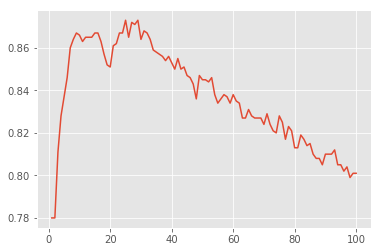

In [80]:
"""
name = "predictions_knn_cnn_metric"
with open(name + '.pkl', 'rb') as f:
    predictions = pickle.load(f)
"""
## Calculate accuracy 
accuracy = list()
for k in range(1,k_test+1):
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))
    
## Plotting accuracy (y_axis) vs K value (x_axis) curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

(1, 1, 28, 28)

In [ ]:
MODEL_FOLDER = '../Autoencoders/model/demo_autoencoder_197.pkl'

In [233]:
import sys
import torch 
import numpy
import scipy.misc
#import argparse

sys.path.append("..")
from Autoencoders.network import *
from Autoencoders.torch_utils import *

import random
import numpy as np

In [243]:
idx = 1
path = '../Dataset/data/train_test_final/'

test_X = np.load(path + 'test_X.npy') 
img = random_img[idx].reshape(1,1,28,28)
img = torch.from_numpy(img)

test_Y = np.load(path + 'test_Y.npy') 
label = test_Y[idx]

MODEL_FOLDER = '../Autoencoders/model/demo_autoencoder_197.pkl'
encoder, decoder = torch.load(MODEL_FOLDER, map_location='cpu')

In [241]:
## Load the datasets
"""train_X = torch.from_numpy(np.load(data_path + "train_X.npy"))
train_Y = torch.from_numpy(np.load(data_path + "train_Y.npy"))
train_Y = train_Y.unsqueeze(1)
test_X = torch.from_numpy(np.load(data_path + "test_X.npy"))
test_Y = torch.from_numpy(np.load(data_path + "test_Y.npy"))
test_Y = test_Y.unsqueeze(1)
data_list = [(train_X, train_Y), (test_X, test_Y)]"""


## Initialize embeddings tensor
#embeddings = torch.empty(1,emb_dim)

batch_size = img.shape[0]
e_output = encoder(img.float(), batch_size) #.float() otherwise an error is reporduced
#embedding = torch.cat((e_output,labels.float()), 1) #.float() otherwise an error is reporduced
#embeddings = torch.cat((embeddings, embedding))
embeddings = e_output.detach().numpy()

In [247]:
def eucl_dist(instance, dataset):
    
    #temp_inst = instance.reshape(1,-1)
    #temp_inst = temp_inst.repeat(len(dataset), axis=0)
    eucl_dist = np.linalg.norm((instance - dataset[:,:-1]), axis=1)
    eucl_dist_sorted = [(eucl_dist[i], dataset[i,-1]) for i in range(len(dataset))]
    eucl_dist_sorted.sort()
    
    return eucl_dist_sorted

In [251]:
with open("relevant_idx", "rb") as fp:   # Unpickling
    relevant_idx = pickle.load(fp)
    
relevant_idx = [int(i) for i in relevant_idx]
emb_train = emb[relevant_idx]

In [258]:
k = 50
sorted_dist = eucl_dist(embeddings, emb_train)
temp_first_k = sorted_dist[:k]
temp_labels = [digit[1] for digit in temp_first_k]

## Pick label that has majority count and append to prediction list
temp_list = [temp_labels.count(i) for i in temp_labels]
prediction = temp_labels[temp_list.index(max(temp_list))]
prediction

6.0

In [246]:
embeddings.shape

(1, 196)

6.0

In [4]:
np.load('web.npy').reshape(28,28)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 